<a href="https://colab.research.google.com/github/PriyanshiCocaCola/Deep-learning-Project/blob/main/DLP_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import matplotlib.pyplot as plt
import glob as gb
import seaborn as sns
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import plotly.express as px
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Loading the dataset metadata and visualizing class distribution
info_file = '/content/drive/My Drive/dataset/Monkeypox_Dataset_metadata.csv'

info = pd.read_csv(info_file)
info.head()

fig = px.pie(
    names=info.Label.unique(),
    values=info.Label.value_counts(),
    hole=0.2,
    width=500,
    height=500
)
fig.update_layout({'title': {'text': 'Distribution of the Class', 'x': 0.45}})
fig.show()

In [3]:
image_height = 300
image_width = 300
batch_size = 8
tpath = '/content/drive/My Drive/dataset/Original Images/Original Images'

In [4]:
# Using the keras to load and split the dataset into the training and the validation sets
training_data = keras.preprocessing.image_dataset_from_directory(
    tpath,
    batch_size=batch_size,
    image_size=(image_height, image_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='training'
)

validation_data = keras.preprocessing.image_dataset_from_directory(
    tpath,
    batch_size=batch_size,
    image_size=(image_height, image_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='validation'
)

Found 228 files belonging to 2 classes.
Using 183 files for training.
Found 228 files belonging to 2 classes.
Using 45 files for validation.


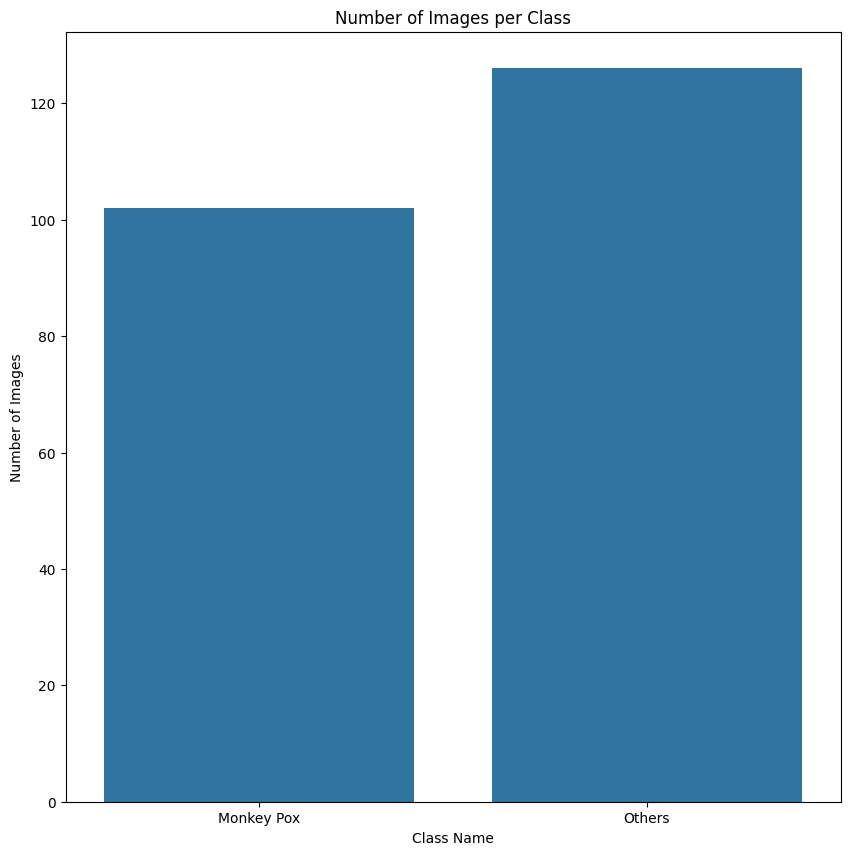

In [5]:
class_names = []
class_count = []
train_examples = 0

for f in os.listdir(tpath):
    files = gb.glob(pathname=str(tpath + "//" + f + "/*"))
    class_names.append(f)
    class_count.append(len(files))
    train_examples += len(files)

plt.figure(figsize=(10,10))
sns.barplot(x=class_names, y=class_count)
plt.title('Number of Images per Class')
plt.xlabel('Class Name')
plt.ylabel('Number of Images')
plt.show()

In [6]:
# Defining Image Data Generator
train_gen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

Found 228 images belonging to 2 classes.


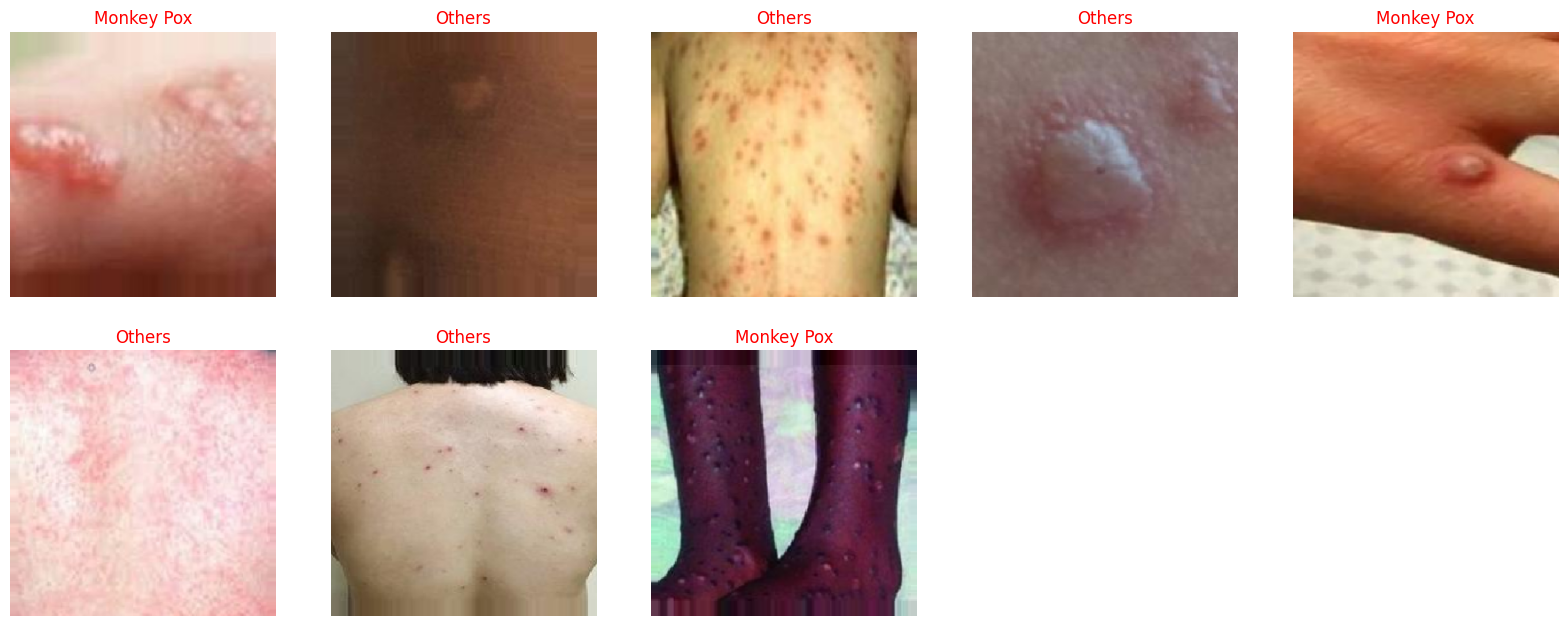

In [7]:
# Displaying Augmented Images
train_batch = train_gen.flow_from_directory(
    directory=tpath,
    target_size=(image_height, image_width),
    batch_size=batch_size,
)

g_dict = train_batch.class_indices
classes = list(g_dict.keys())
images, labels = next(train_batch)

length = len(labels)
sample = min(length, 30)

plt.figure(figsize=(20, 20))

for i in range(sample):
    plt.subplot(5, 5, i + 1)
    image = images[i]
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color='red', fontsize=12)
    plt.axis('off')
plt.show()

In [22]:
from keras import layers
from tensorflow.keras.optimizers import Adam
resnet_model = Sequential()
pretrained_model = keras.applications.ResNet50(
    include_top=False,
    input_shape=(image_height, image_width, 3),
    pooling='avg',
    weights='imagenet'
)

for layer in pretrained_model.layers:
    layer.trainable = False

resnet_model.add(pretrained_model)
resnet_model.add(layers.Flatten())
resnet_model.add(layers.Dense(1024, activation='relu'))
resnet_model.add(layers.Dense(2, activation='softmax'))

resnet_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [23]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import SGD

# Function to build the ResNet model
def build_resnet_model():
    resnet_model = models.Sequential()
    pretrained_model = keras.applications.ResNet50(
        include_top=False,
        input_shape=(image_height, image_width, 3),
        pooling='avg',
        weights='imagenet'
    )

    for layer in pretrained_model.layers:
        layer.trainable = False  # Freeze the pretrained layers

    resnet_model.add(pretrained_model)
    resnet_model.add(layers.Flatten())
    resnet_model.add(layers.Dense(1024, activation='relu'))
    resnet_model.add(layers.Dropout(0.5))
    resnet_model.add(layers.Dense(2, activation='softmax'))

    resnet_model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy']
    )
    return resnet_model

In [24]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

# Extract images and labels from `training_data`
images = []
labels = []

for img, label in training_data:
    images.append(img.numpy())
    labels.append(label.numpy())

images = np.concatenate(images)  # Combine all image batches
labels = np.concatenate(labels)  # Combine all label batches



In [25]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# K-fold cross-validation setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
all_scores = []

# Loop through each fold
for train_idx, val_idx in skf.split(images, labels):
    # Create train and validation sets
    train_images, val_images = images[train_idx], images[val_idx]
    train_labels, val_labels = labels[train_idx], labels[val_idx]

    # Convert to TensorFlow datasets and batch
    train_data = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(8)
    val_data = tf.data.Dataset.from_tensor_slices((val_images, val_labels)).batch(8)

    # Reinitialize the model for each fold
    resnet_model = build_resnet_model()  # Create the ResNet model

    # Define callbacks for learning rate reduction and early stopping
    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.8,  # Reduce the learning rate by 20%
        patience=10,  # Number of epochs with no improvement before reducing LR
        min_lr=1e-6,  # Minimum learning rate to stop reducing
        verbose=1
    )
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=15,  # Stop after 15 epochs with no improvement
        restore_best_weights=True,  # Restore the best weights when stopping
        verbose=1
    )

    # Train the model with callbacks
    history = resnet_model.fit(
        train_data,
        validation_data=val_data,
        epochs=40,  # Adjust as needed for your dataset
        callbacks=[lr_scheduler, early_stopping]  # Include callbacks
    )

    # Evaluate the model for the current fold
    scores = resnet_model.evaluate(val_data)
    print(f"Fold {fold_no}, Validation Accuracy: {scores[1]}")
    all_scores.append(scores[1])
    fold_no += 1

# Print the average validation accuracy across all folds
print("Average Validation Accuracy:", np.mean(all_scores))


Epoch 1/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 25s 705ms/step - accuracy: 0.6152 - loss: 1.5790 - val_accuracy: 0.5946 - val_loss: 0.7140 - learning_rate: 0.0010
Epoch 2/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - accuracy: 0.7942 - loss: 0.6199 - val_accuracy: 0.6757 - val_loss: 0.6910 - learning_rate: 0.0010
Epoch 3/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.8208 - loss: 0.4041 - val_accuracy: 0.6757 - val_loss: 0.8228 - learning_rate: 0.0010
Epoch 4/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - accuracy: 0.8456 - loss: 0.4635 - val_accuracy: 0.7297 - val_loss: 0.6647 - learning_rate: 0.0010
Epoch 5/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.8800 - loss: 0.3068 - val_accuracy: 0.5676 - val_loss: 1.9716 - learning_rate: 0.0010
Epoch 6/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.9437 - loss: 0.2670 - val_accuracy: 0.5676 - val_loss: 1.4368 - learning_rate: 0.0010
Epoch 7/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.8533 - loss: 0.5087 -

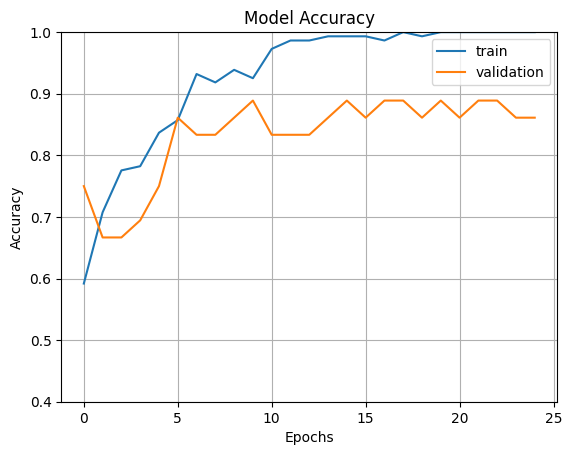

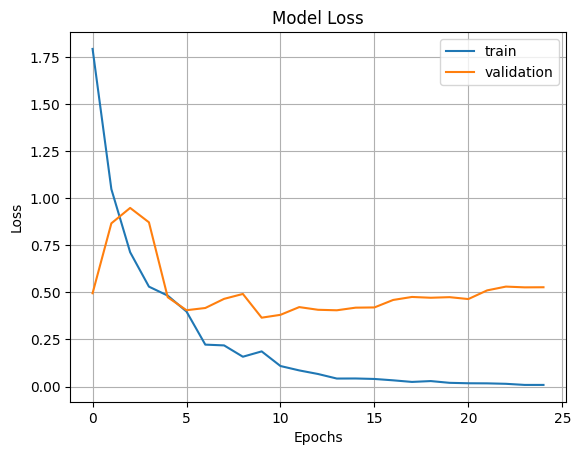

In [26]:
# Accuracy Plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.grid()
plt.axis(ymin=0.4,ymax=1)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

# Loss Plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.grid()
plt.show()

In [27]:
# Prediction Function
def predict_image(image_path, model, class_names):
    img = load_img(image_path)
    img = img.resize((image_height, image_width))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    y_pred = model.predict(x)
    class_idx = np.argmax(y_pred, axis=1)[0]
    return class_names[class_idx]

In [28]:
# Define class names for prediction

class_names = ['MonkeyPox', 'Other']

# Test on a Monkeypox image
image_path = '/content/drive/My Drive/dataset/Original Images/Original Images/Monkey Pox/M18_01.jpg'
print('Predicted Class name:', predict_image(image_path, resnet_model, class_names))

# Test on an Other image
image_path = '/content/drive/My Drive/dataset/Original Images/Original Images/Others/NM07_01.jpg'
print('Predicted Class name:', predict_image(image_path, resnet_model, class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted Class name: MonkeyPox
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Predicted Class name: Other


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 919ms/step


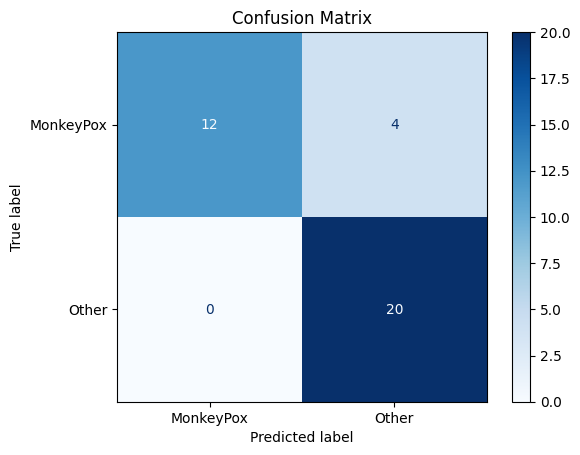

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions for the entire validation set
y_true = val_labels
y_pred = resnet_model.predict(val_data)
y_pred_classes = np.argmax(y_pred, axis=1)

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


In [30]:
from sklearn.metrics import classification_report

# Print classification report
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print('Classification Report:\n', report)


Classification Report:
               precision    recall  f1-score   support

   MonkeyPox       1.00      0.75      0.86        16
       Other       0.83      1.00      0.91        20

    accuracy                           0.89        36
   macro avg       0.92      0.88      0.88        36
weighted avg       0.91      0.89      0.89        36

